### jet_estimate_normal
- for each point, find k nearest neighbors
- fit a polynomial surface (by least squares)
- estimate the local normal from gradient of fitted (local,smooth) polynomial

### jet_smooth_point_set
- for each point, find k nearest neighbors
- fit a polynomial surface (by least squares)
- project each point onto the (local,smooth) polynomial surface

this is quite similar to using PCA for smoothing point cloud except there, the local approximation was obtained by the eigenvectors of the covariance matrix

give a set of k-neighborhood points $\{ \vec{p}_i = (x_i,y_i,z_i)\}$ where $0 \leq i \leq k$ find a function $f(x,y,z)$ that is quadratic in $x,y,z$ i.e  
$$ f(x,y,z) = a_1x + a_2y + a_3z + a_4x^2 + a_5xy + a_6xz + a_7y^2 + ... = 0 $$ 
- This function $f(x,y,z)$ is the _level set_ of our points
- the best fit function $f(x,y,z)$ is obtained by minimizing $\Vert \mathbf{X} \vec{a} \Vert$ where the $i^{th}$ row of $\mathbf{X}$ is just $[x_i, y_i, z_i, x_i^2, x_iy_i, ... z_i^2]$ and $\vec{a} = [a_1, a_2, a_3, ... a_9]$ . $\vec{a}$ is normalized to have unit magnitude to avoid the trivial solution for the minimization problem
- the smallest singular vector of $\mathbf{X}$ gives the coefficients of $f$.
- In PCA we would have been interested in eigenvectors of the covariance matrix. Here we're interested in null-vectors $\mathbf{X}\vec{v} = 0$
- Then the gradient at the origin (the point of interest) is just $\vec{g} = [a_1,a_2,a_3]$ and the normal direction is the normalized $\vec{g}$.




In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


In [2]:
# generate the X matrix for an input (x,y,z)
def XMatrix(x, y, z):
    degree = 2
    terms = []
    for i in range(degree + 1):
        for j in range(degree + 1 - i):
            for k in range(degree + 1 - i - j):
                if i + j + k > 0:  # skip constant
                    terms.append((x ** i) * (y ** j) * (z ** k))
    return np.stack(terms, axis=-1)

In [3]:
def jet_estimate_normals(points, k = 20):
    N = len(points)
    normals = np.zeros((N,3))
    nn = NearestNeighbors(n_neighbors = k+1).fit(points)

    # iterate over all points
    for i in range(N):
        # find neighbors for each point
        neighbor_points = points[i:i+1] # exclude the point itself 
        _ , idx = nn.kneighbors(neighbor_points)
        neighbors = points[idx[0][1:]]  # shape (k, 3)
        centered = neighbors - points[i]  # translate so p_i is at origin
    
        # construct the X matrix
        X = XMatrix(centered[:, 0], centered[:, 1], centered[:, 2])

        # Find null-vectors of X i.e solve for Xv = 0
        _,_,VT = np.linalg.svd(X, full_matrices = False)
        a = VT[-1,:] # smallest singular value

        grad = a[[0,2,5]] # the linear coefficients (a_0.x , a_2.y , a_5.z)
        grad = grad/(np.linalg.norm(grad) + 1e-10)
        normals[i] = grad

    return normals        
        

In [4]:
# Generate a noisy paraboloid z = x^2 + y^2
np.random.seed(0)
n = 1000
x = np.random.uniform(-1, 1, n)
y = np.random.uniform(-1, 1, n)
z = x**2 + y**2 + 0.05 * np.random.randn(n)
points = np.column_stack((x, y, z))
normals = jet_estimate_normals(points, k=10)

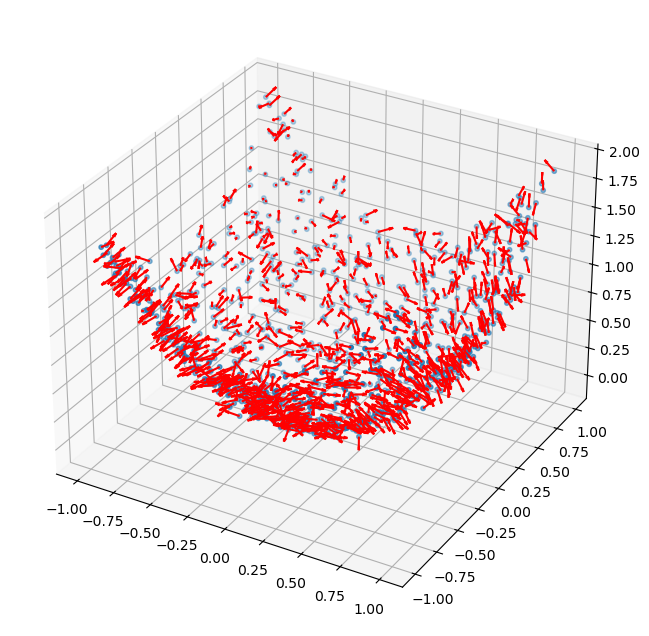

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], s=10)
ax.quiver(points[:,0], points[:,1], points[:,2],
          normals[:,0], normals[:,1], normals[:,2],
          length=0.1, color='r')
plt.show()


## The normals could be improved with some reorientation (using minimum spanning tree)
- build a KNN graph
- compute the edge-weight between two neighboring normals as w_{ij} = 1 - |n_1.n_j|
- this weight is smaller when the normals are oriented
- build a MST using these weights
- pick a random root and propagate orientation along the MST. If a child normal has opposite orientation to it's parent (dot < 0) flip it
- 

In [6]:
def orient_normals_mst(points,normals,k=10):
    N = len(points)
    nn = NearestNeighbors(n_neighbors=k+1).fit(points)
    dist,idx = nn.kneighbors(points)

    # build adjacency matrix of graph
    adjacency = np.full((N,N),np.inf)
    for i in range(N): # iterate over each point
        for j in idx[i][1:]: # iterate over point's neighbors
            w = 1 - abs(np.dot(normals[i],normals[j]))# w_ij
            adjacency[i,j] = w
            adjacency[j,i] = w

    # propogate orientation using Prim's algorithm
    visited = np.zeros(N,dtype=bool)
    parent = -np.ones(N,dtype=int)
    key = np.full(N,np.inf)
    key[0] = 0 # start from node 0

    for i in range(N):
        u = np.argmin(np.where(visited,np.inf,key))
        visited[u] = True
        for v in range(N):
            if not visited[v] and adjacency[u,v] < key[v]:
                key[v] = adjacency[u,v]
                parent[v] = u

    # parent is the MST
    oriented_normals = normals.copy()
    for i in range(1,N):
        p = parent[i]
        if p == -1:
            continue
        if np.dot(oriented_normals[i],oriented_normals[p]) < 0:
            oriented_normals[i] *= -1

    return oriented_normals

In [7]:
normals_oriented = orient_normals_mst(points, normals, k=10)

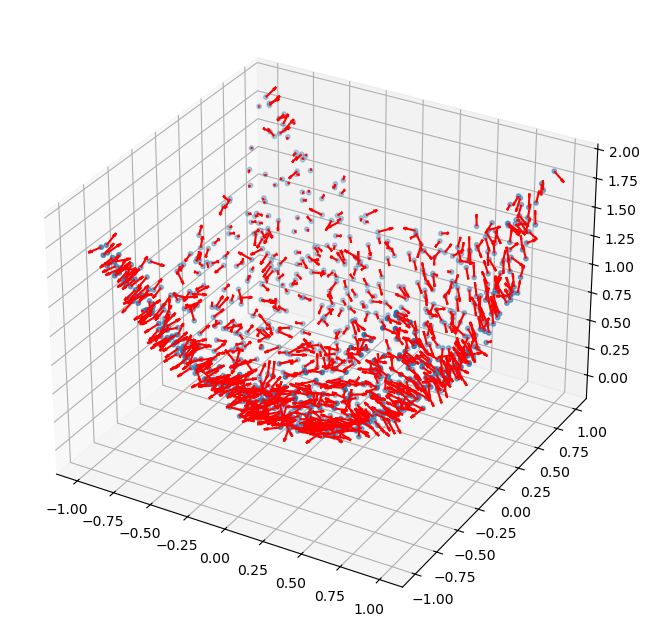

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], s=10)
ax.quiver(points[:,0], points[:,1], points[:,2],
          normals_oriented[:,0], normals_oriented[:,1], normals_oriented[:,2],
          length=0.1, color='r')
plt.show()
